In [ ]:
import random
import numpy as np
import shutil
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Set dataset path
import os
source_path = "/content/drive/MyDrive/dataset"
destination_path = "/content/drive/MyDrive/dataset/Processed data"

# Clear existing processed dataset if it exists
if os.path.exists(destination_path):
    shutil.rmtree(destination_path)

os.makedirs(destination_path, exist_ok=True)

for split in ['train', 'valid', 'test']:
    for class_name in ['wildfire', 'no_wildfire']:
        os.makedirs(os.path.join(destination_path, split, class_name), exist_ok=True)

wildfire_dir = os.path.join(source_path, 'wildfire')
no_wildfire_dir = os.path.join(source_path, 'nowildfire')
wildfire_images = os.listdir(wildfire_dir)
no_wildfire_images = os.listdir(no_wildfire_dir)

In [ ]:
print(f"{len(wildfire_images)} - Wildfire  Images")
print(f"{len(no_wildfire_images)} - nowildfire  Images")


22738 - Wildfire  Images
20170 - nowildfire  Images


In [ ]:
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1
IMAGES_PER_CLASS = 10000

In [ ]:
# Function to split and copy images
from tqdm.notebook import tqdm
from PIL import Image
def process_images(image_list, source_dir, class_name):
        if len(image_list) > IMAGES_PER_CLASS:
            print(f"Randomly selecting {IMAGES_PER_CLASS} images from {len(image_list)} available {class_name} images")
            image_list = random.sample(image_list, IMAGES_PER_CLASS)
        else:
            print(f"Using all {len(image_list)} available {class_name} images (less than {IMAGES_PER_CLASS})")

        # Shuffle images
        random.shuffle(image_list)

        # Calculate split indices
        train_end = int(len(image_list) * train_ratio)
        valid_end = train_end + int(len(image_list) * valid_ratio)

        # Split into train, validation, and test sets
        train_images = image_list[:train_end]
        valid_images = image_list[train_end:valid_end]
        test_images = image_list[valid_end:]

        print(f"\n{class_name} split:")
        print(f"Train: {len(train_images)}")
        print(f"Validation: {len(valid_images)}")
        print(f"Test: {len(test_images)}")

        # Copy and resize images for train set
        print(f"\nProcessing {class_name} training images...")
        for img_name in tqdm(train_images):
            src_path = os.path.join(source_dir, img_name)
            dst_path = os.path.join(destination_path, 'train', class_name, img_name)

            # Open, resize, and save image
            try:
                img = Image.open(src_path)
                img = img.resize((224, 224))
                img.save(dst_path)
            except Exception as e:
                print(f"Error processing {img_name}: {e}")

        # Copy and resize images for validation set
        print(f"\nProcessing {class_name} validation images...")
        for img_name in tqdm(valid_images):
            src_path = os.path.join(source_dir, img_name)
            dst_path = os.path.join(destination_path, 'valid', class_name, img_name)

            try:
                img = Image.open(src_path)
                img = img.resize((224, 224))
                img.save(dst_path)
            except Exception as e:
                print(f"Error processing {img_name}: {e}")

        # Copy and resize images for test set
        print(f"\nProcessing {class_name} test images...")
        for img_name in tqdm(test_images):
            src_path = os.path.join(source_dir, img_name)
            dst_path = os.path.join(destination_path, 'test', class_name, img_name)

            try:
                img = Image.open(src_path)
                img = img.resize((224, 224))
                img.save(dst_path)
            except Exception as e:
                print(f"Error processing {img_name}: {e}")

In [ ]:
process_images(wildfire_images, wildfire_dir, 'wildfire')
process_images(no_wildfire_images, no_wildfire_dir, 'no_wildfire')

Randomly selecting 20170 images from 22738 available wildfire images

wildfire split:
Train: 16136
Validation: 2017
Test: 2017

Processing wildfire training images...


  0%|          | 0/16136 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def count_images(directory):
        return sum(len(files) for _, _, files in os.walk(directory))

In [ ]:
train_count = count_images(os.path.join(destination_path, 'train'))
valid_count = count_images(os.path.join(destination_path, 'valid'))
test_count = count_images(os.path.join(destination_path, 'test'))
total_count = train_count + valid_count + test_count

print("\nDataset preparation complete!")
print(f"Total images: {total_count}")
print(f"Training images: {train_count} ({train_count/total_count:.1%})")
print(f"Validation images: {valid_count} ({valid_count/total_count:.1%})")
print(f"Test images: {test_count} ({test_count/total_count:.1%})")


Dataset preparation complete!
Total images: 5000
Training images: 4000 (80.0%)
Validation images: 500 (10.0%)
Test images: 500 (10.0%)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
random.seed(42)
np.random.seed(42)

In [ ]:
BASE_DIR = '/content/drive/MyDrive/dataset/Processed data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Create output directory for saving model and results
OUTPUT_DIR = "/content/drive/MyDrive/dataset/Results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
 #Define hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0001

EXPECTED_TOTAL_IMAGES = 5000
EXPECTED_IMAGES_PER_CLASS = 2500

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    preprocessing_function=lambda x: x * np.random.choice(
        [1, np.random.uniform(0.7, 0.9)],
        size=1,
        p=[0.9, 0.1]
    )[0] if np.random.random() < 0.1 else x
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 4000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
class_labels = {v: k for k, v in train_generator.class_indices.items()}

In [ ]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# callbacks
checkpoint = ModelCheckpoint(
    os.path.join(OUTPUT_DIR, 'best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6470 - loss: 0.6233 - precision: 0.6416 - recall: 0.6227
Epoch 1: val_accuracy improved from -inf to 0.85417, saving model to /content/drive/MyDrive/dataset/Results/best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 584s 5s/step - accuracy: 0.6476 - loss: 0.6228 - precision: 0.6421 - recall: 0.6236 - val_accuracy: 0.8542 - val_loss: 0.3890 - val_precision: 0.8077 - val_recall: 0.9130 - learning_rate: 1.0000e-04
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8048 - loss: 0.4456 - precision: 0.7740 - recall: 0.8618
Epoch 2: val_accuracy did not improve from 0.85417
125/125 ━━━━━━━━━━━━━━━━━━━━ 563s 5s/step - accuracy: 0.8048 - loss: 0.4455 - precision: 0.7740 - recall: 0.8619 - val_accuracy: 0.8500 - val_loss: 0.3836 - val_precision: 0.8435 - val_recall: 0.8435 - learning_rate: 1.0000e-04
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8398 - loss: 0.4071 - precision: 0.8084 - recall: 0.8911
Ep

In [ ]:
model.load_weights(os.path.join(OUTPUT_DIR, 'best_model.keras'))

In [ ]:
# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"Test F1 Score: {f1_score:.4f}")


test_generator.reset()
y_pred = model.predict(test_generator, verbose=1)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.8318 - loss: 0.3559 - precision: 0.3860 - recall: 0.5348

Test Accuracy: 0.8660
Test Precision: 0.8327
Test Recall: 0.9160
Test F1 Score: 0.8724
16/16 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step


In [ ]:
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"Test F1 Score: {f1_score:.4f}")


Test Accuracy: 0.8660
Test Precision: 0.8327
Test Recall: 0.9160
Test F1 Score: 0.8724


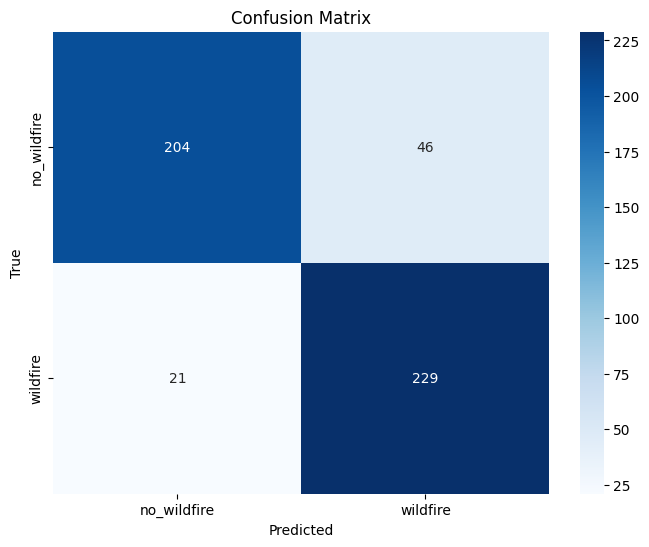

In [ ]:
# confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(class_labels.values()),
            yticklabels=list(class_labels.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
plt.show()


Classification Report:
              precision    recall  f1-score   support

 no_wildfire       0.91      0.82      0.86       250
    wildfire       0.83      0.92      0.87       250

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



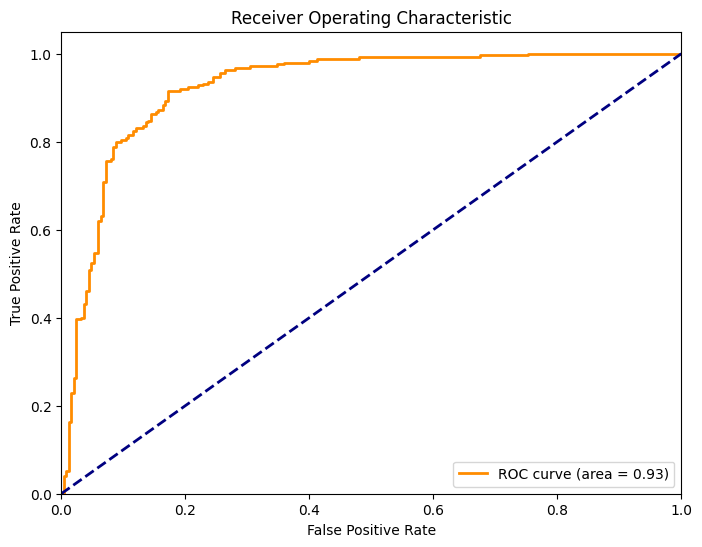

In [ ]:
# classification report
cr = classification_report(y_true, y_pred_binary, target_names=list(class_labels.values()))
print("\nClassification Report:")
print(cr)

with open(os.path.join(OUTPUT_DIR, 'classification_report.txt'), 'w') as f:
    f.write(cr)

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(os.path.join(OUTPUT_DIR, 'roc_curve.png'))
plt.show()

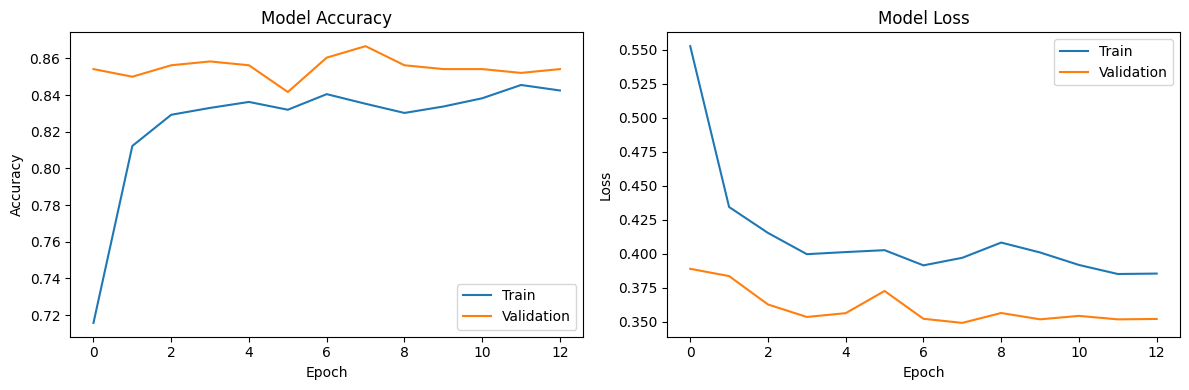

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'))
plt.show()



In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_model(base_model):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [ ]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_vgg16 = build_model(base_model)

history_vgg16 = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=15,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

NameError: name 'GlobalAveragePooling2D' is not defined